In [4]:
import csv
import numpy as np
import cv2
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import tensorflow as tf
#tf.python.control_flow_ops = tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D,Cropping2D
#from keras.layers import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam


In [2]:
import os.path as osp
def loadData(rootpath, filename):
    fn=osp.join(rootpath, filename)
    with open(fn) as csvfile:
        reader = csv.DictReader(csvfile, skipinitialspace=True)
        db=[row for row in reader]
    return [{'left': osp.join(rootpath, row['left']), 
             'right': osp.join(rootpath, row['right']), 
             'center': osp.join(rootpath, row['center']), 
             'steering': float(row['steering']),
             'throttle': float(row['throttle'])} for row in db]

In [3]:

db=loadData('/home/carnd/CarND-Behavioral-Cloning-P3/my_data','driving_log.csv')
db = shuffle(db)


steering value:  0.03007519
Throttle value:  1.0


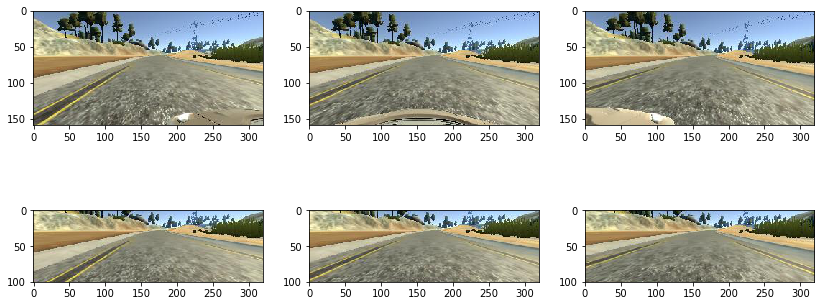

In [8]:
%matplotlib inline

ROW = db[68342]
print('steering value: ', ROW['steering'])
print('Throttle value: ', ROW['throttle'])

plt.figure(figsize=(14,6))
plt.subplot(2, 3, 1)
randomImg=mpimg.imread(ROW['left'])
plt.imshow(randomImg)
plt.subplot(2, 3, 2)
randomImg=mpimg.imread(ROW['center'])
plt.imshow(randomImg)
plt.subplot(2, 3, 3)
randomImg=mpimg.imread(ROW['right'])
plt.imshow(randomImg)

plt.subplot(2, 3, 4)
randomImg=mpimg.imread(ROW['left'])
plt.imshow(randomImg[35:135,:,:])
plt.subplot(2, 3, 5)
randomImg=mpimg.imread(ROW['center'])
plt.imshow(randomImg[35:135,:,:])
plt.subplot(2, 3, 6)
randomImg=mpimg.imread(ROW['right'])
plt.imshow(randomImg[35:135,:,:])

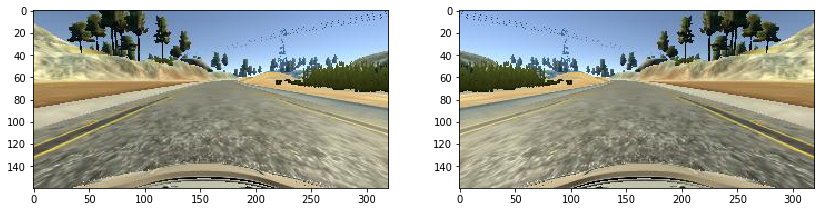

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
randomImg=mpimg.imread(ROW['center'])
plt.imshow(randomImg)
plt.subplot(1, 2, 2)
randomImg=mpimg.imread(ROW['center'])
plt.imshow(cv2.flip(randomImg,1))

In [4]:
def loadImgSteer(db, steerCorrection):
    imgs  = []
    steer = []
    imgs=[{'FT': row['left']} for row in db]
    imgs.extend([{'FT':row['center']} for row in db])
    imgs.extend([{'FT':row['right']} for row in db])
    steer=[row['steering']+steerCorrection for row in db]
    steer.extend([row['steering'] for row in db])
    steer.extend([row['steering']-steerCorrection for row in db])
    return imgs,np.array(steer, np.float32)

In [5]:
images,steering = loadImgSteer(db, 0.4)
images,steering = shuffle(images,steering)

In [6]:
numSamples    = int(len(images)/1)
Trainfraction = 0.9
numTrain      = int(numSamples*Trainfraction+0.5)
numValid      = int(numSamples*(1-Trainfraction)+0.5)
imgTrain      = images[0:numTrain]
steerTrain    = steering[0:numTrain]
imgValid      = images[numTrain:]
steerValid    = steering[numTrain:]


In [7]:
def readImg(imgData):
    img=mpimg.imread(imgData['FT'])
    return np.array(img[35:135,:,:], np.float32)

def generator_data(X, y, batch_size):
    l=len(y)
    while 1:
        nb=0
        Xb=[]
        yb=[]
        i=0
        while nb<batch_size:
            if i%2==0:
                Xb.append(readImg(X[i]))
                yb.append(y[i])
            else:
                Xb.append(cv2.flip(readImg(X[i]), 1))
                yb.append(-y[i])
            nb=nb+1;
            i=i+1; 
            if i>=l:
                i=0
        yield np.array(Xb, np.float32), np.array(yb, np.float32)

In [ ]:
def NetModel(rate):
    model = Sequential()
    #model.add(Cropping2D(cropping=((60, 30), (0, 0)),input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - .5, input_shape=(100,320,3)))
    model.add(Convolution2D(24, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(36, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(48, 5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    adam=Adam(lr=rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(adam, 'mean_squared_error', ['accuracy', 'mean_squared_error'])
    return model

In [ ]:
model=NetModel(0.00025)  
#model = SModel()
history = model.fit_generator(generator_data(imgTrain, steerTrain, 50),
                              samples_per_epoch=int(numTrain/50)*50, nb_epoch=3)



#model.summary()
model.save('model11.h5')

Epoch 1/3
201700/201700 [==============================] - 1188s - loss: 0.0376 - acc: 0.0199 - mean_squared_error: 0.0376  
Epoch 2/3
201700/201700 [==============================] - 1182s - loss: 0.0043 - acc: 0.0200 - mean_squared_error: 0.0043  
Epoch 3/3
194450/201700 [===========================>..] - ETA: 42s - loss: 0.0027 - acc: 0.0200 - mean_squared_error: 0.0027